<a href="https://colab.research.google.com/github/hyunholee26/short-term-river-level-prediction-using-LSTM-with-MC-dropout/blob/main/%5Bwlp_samrang%5D_2_lstm_uncertainty_w_std_wo_diff1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)


1.15.2


In [ ]:
# 14년1월 ~ 21년 6월까지 데이터를 활용
# openAPI를 통해 6개월 단위로 수집가능함에 따라, 병합처리 필요

path = '/content/drive/MyDrive/data/flood/'

raw_period = {'startdt': ['20140101', '20140701', '20150101', '20150701', '20160101', '20160701', '20170101', '20170701', '20180101', '20180701', '20190101', '20190701', '20200101', '20200701', '20210101'],
                'enddt': ['20140630', '20141231', '20150630', '20151231', '20160630', '20161231', '20170630', '20171231', '20180630', '20181231', '20190630', '20191231', '20200630', '20201231', '20210630']}

df_period = pd.DataFrame(raw_period)
df_period

,startdt,enddt
0,20140101,20140630
1,20140701,20141231
2,20150101,20150630
3,20150701,20151231
4,20160101,20160630
5,20160701,20161231
6,20170101,20170630
7,20170701,20171231
8,20180101,20180630
9,20180701,20181231


In [ ]:
raw_obscd = {'obscd': ['2022610', '2020675', '2020650', '2021685', '2020680', '20224050', '20204020', '20204030', '20214020'],
            'desc': ['wl밀양시 삼랑진교', 'wl창원시 수산대교','wl창녕군 청암리','wl밀양시 남포동', 'wl김해시 오서교', 'rf밀양시 삼랑진교', 'rf창원시 수산대교', 'rf창녕군 청암리', 'rf밀양시 남포동']}

df_obscd = pd.DataFrame(raw_obscd)
df_obscd

,obscd,desc
0,2022610,wl밀양시 삼랑진교
1,2020675,wl창원시 수산대교
2,2020650,wl창녕군 청암리
3,2021685,wl밀양시 남포동
4,2020680,wl김해시 오서교
5,20224050,rf밀양시 삼랑진교
6,20204020,rf창원시 수산대교
7,20204030,rf창녕군 청암리
8,20214020,rf밀양시 남포동


In [ ]:
# 기준이 되는 Date를 생성함

start = datetime.datetime.strptime("2015050101", "%Y%m%d%H")
end = datetime.datetime.strptime("2020110123", "%Y%m%d%H")
date_generated = [start + datetime.timedelta(hours=x) for x in range(0, (end-start).days * 24 + 23)]

df = pd.DataFrame(date_generated, columns =['Date'])
df['ymdh'] = df['Date'].apply(lambda x: int(x.strftime('%Y%m%d%H'))) 
df

,Date,ymdh
0,2015-05-01 01:00:00,2015050101
1,2015-05-01 02:00:00,2015050102
2,2015-05-01 03:00:00,2015050103
3,2015-05-01 04:00:00,2015050104
4,2015-05-01 05:00:00,2015050105
...,...,...
48282,2020-11-01 19:00:00,2020110119
48283,2020-11-01 20:00:00,2020110120
48284,2020-11-01 21:00:00,2020110121
48285,2020-11-01 22:00:00,2020110122


In [ ]:
# 앞에서 만든 데이터프레임을 이용하여, 각 파일들을 읽고 합치는 작업을 함

for i, row_i in df_obscd.iterrows():
  obscd = row_i['obscd']   
  
  files = glob.glob(path + '*' + obscd + '*.csv')
  files.sort()
  print(files)
  
  # Read files
  for index, file in enumerate(files):
    #print('Reading files ... : ' + file)
    try:
      if(index == 0):
        df_wl = pd.read_csv(file)
      else:
        temp = pd.read_csv(file)
        df_wl = df_wl.append(temp)
    except:
      print('Pass file : ' + file)
      continue
  df_wl.columns = ['ymdh', obscd]
  df = df.merge(df_wl, how='left', on = 'ymdh')
  #display(df)

['/content/drive/MyDrive/data/flood/wl_2022610_20140101_20140630.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20140701_20141231.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20150101_20150630.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20150701_20151231.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20160101_20160630.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20160701_20161231.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20170101_20170630.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20170701_20171231.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20180101_20180630.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20180701_20181231.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20190101_20190630.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20190701_20191231.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20200101_20200630.csv', '/content/drive/MyDrive/data/flood/wl_2022610_20200701_20201231.csv', '/content/drive/MyD

In [ ]:
df

,Date,ymdh,2022610,2020675,2020650,2021685,2020680,20224050,20204020,20204030,20214020
0,2015-05-01 01:00:00,2015050101,1.57,1.16,-1.14,0.92,1.39,0.0,0.0,0.0,0.0
1,2015-05-01 02:00:00,2015050102,1.53,1.12,-1.17,0.91,1.37,0.0,0.0,0.0,0.0
2,2015-05-01 03:00:00,2015050103,1.51,1.09,-1.21,0.90,1.34,0.0,0.0,0.0,0.0
3,2015-05-01 04:00:00,2015050104,1.49,1.07,-1.24,0.90,1.32,0.0,0.0,0.0,0.0
4,2015-05-01 05:00:00,2015050105,1.47,1.05,-1.28,0.89,1.30,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
48282,2020-11-01 19:00:00,2020110119,1.60,1.17,4.85,0.85,1.44,0.0,0.0,0.0,0.0
48283,2020-11-01 20:00:00,2020110120,1.61,1.19,4.85,0.85,1.44,0.0,0.0,0.0,0.0
48284,2020-11-01 21:00:00,2020110121,1.62,1.19,4.86,0.85,1.44,0.0,0.0,0.0,0.0
48285,2020-11-01 22:00:00,2020110122,1.62,1.20,4.86,0.85,1.45,0.0,0.0,0.0,0.0


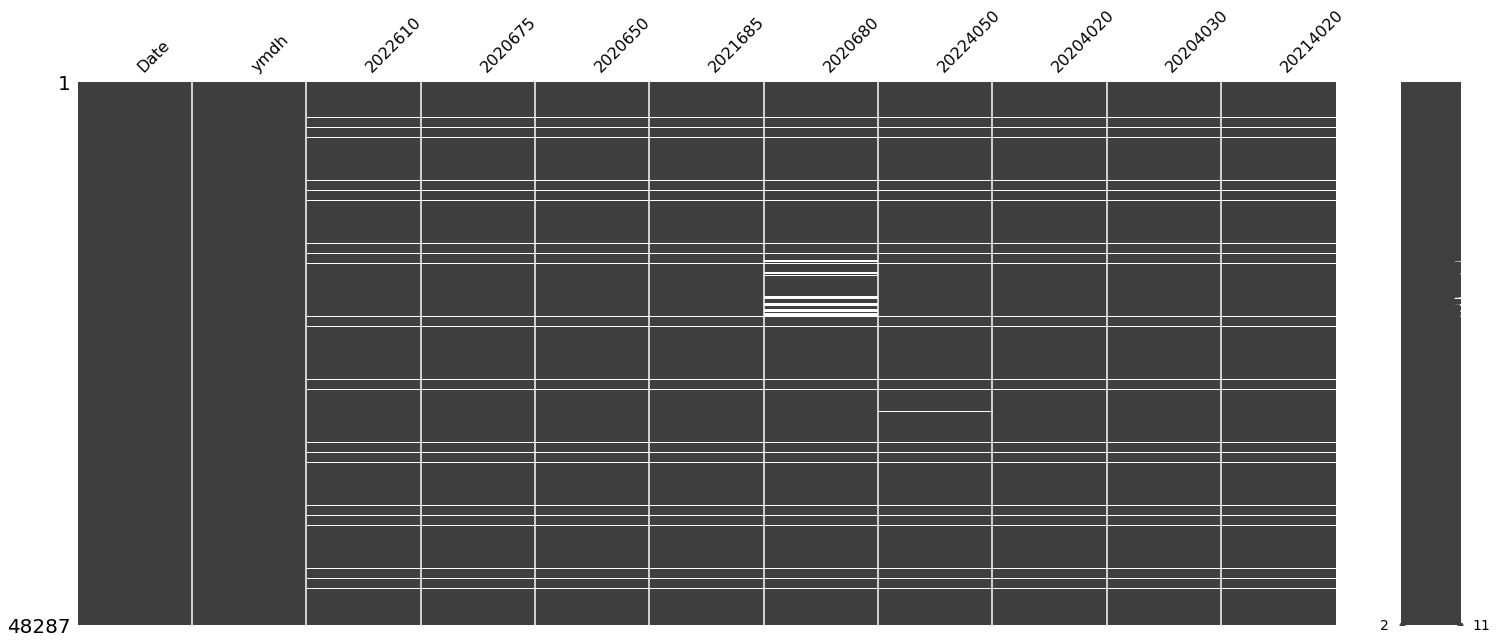

In [ ]:
import missingno as msno

msno.matrix(df)

In [ ]:
# 결측치는 선형보간으로 처리
# LSTM의 경우 연속된 값을 입력으로 해야함에 따라 결측치 보간을 필수적으로 해야함

df['2022610'] = df['2022610'].interpolate(limit=1)
df['2020675'] = df['2020675'].interpolate(limit=1)
df['2020650'] = df['2020650'].interpolate(limit=1)
df['2021685'] = df['2021685'].interpolate(limit=1)
df['2020680'] = df['2020680'].interpolate(limit=1)

df['20224050'] = df['20224050'].fillna(0)
df['20214020'] = df['20214020'].fillna(0)
df['20204020'] = df['20204020'].fillna(0)
df['20204030'] = df['20204030'].fillna(0)

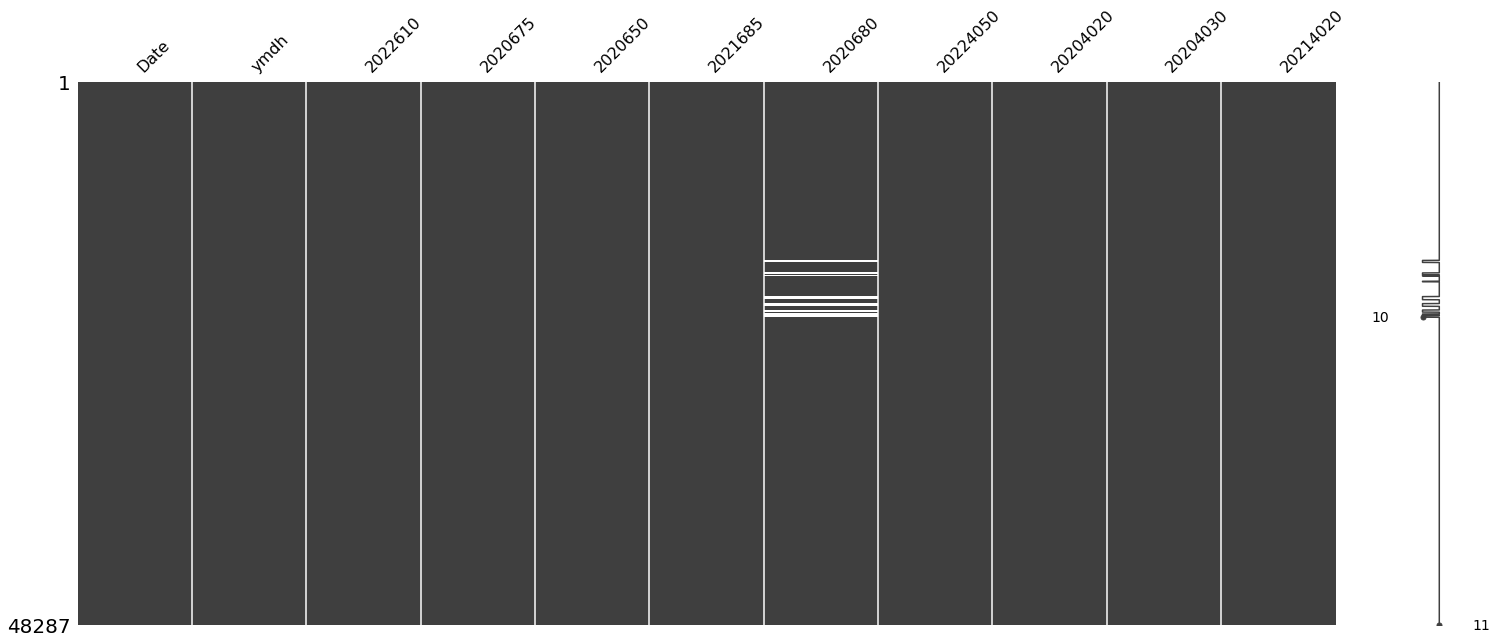

In [ ]:
import missingno as msno

msno.matrix(df)

In [ ]:
df.isnull().sum()

Date           0
ymdh           0
2022610        0
2020675        0
2020650        0
2021685        0
2020680     1422
20224050       0
20204020       0
20204030       0
20214020       0
dtype: int64

,Date,ymdh,2022610,2020675,2020650,2021685,2020680,20224050,20204020,20204030,20214020
46199,2020-08-07 00:00:00,2020080700,1.98,1.655,5.595,1.25,1.780,0.0,0.0,0.0,0.0
46200,2020-08-07 01:00:00,2020080701,2.03,1.720,5.660,1.30,1.840,0.0,0.0,0.0,0.0
46201,2020-08-07 02:00:00,2020080702,2.03,1.740,5.690,1.32,1.860,0.0,0.0,0.0,0.0
46202,2020-08-07 03:00:00,2020080703,2.01,1.730,5.690,1.32,1.850,0.0,1.0,0.0,0.0
46203,2020-08-07 04:00:00,2020080704,1.95,1.700,5.670,1.29,1.820,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
46267,2020-08-09 20:00:00,2020080920,8.30,8.760,13.690,7.96,4.300,0.0,0.0,0.0,0.0
46268,2020-08-09 21:00:00,2020080921,8.23,8.680,13.650,7.89,4.290,0.0,0.0,0.0,0.0
46269,2020-08-09 22:00:00,2020080922,8.15,8.590,13.530,7.79,4.270,0.0,0.0,0.0,0.0
46270,2020-08-09 23:00:00,2020080923,8.07,8.490,13.390,7.70,4.260,1.0,0.0,1.0,1.0


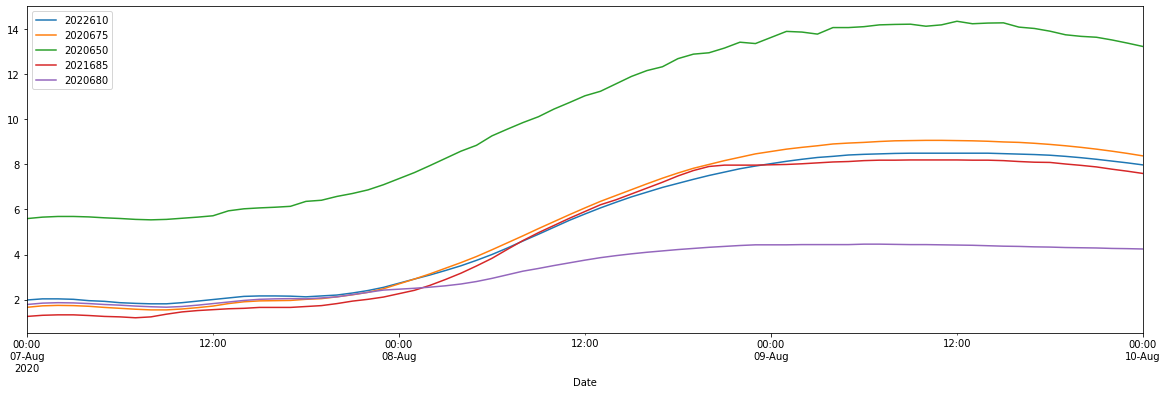

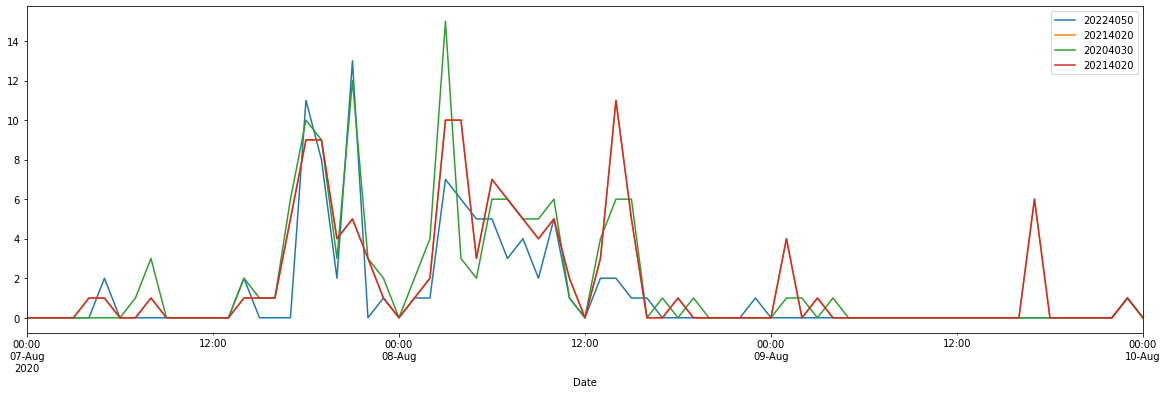

In [ ]:
# 데이터 구조 체크 및 시각화

start = 2020080700
end = 2020081000

df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '2022610', '2020675', '2020650', '2021685', '2020680']].set_index('Date')
df_temp.plot(figsize=(20,6))
df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '20224050', '20214020', '20204030', '20214020']].set_index('Date')
df_temp.plot(figsize=(20,6))

display(df[(df['ymdh'] >= start) & (df['ymdh'] <= end)])

In [ ]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df.drop(columns = ['Date', 'ymdh']).copy()
df_in

,2022610,2020675,2020650,2021685,2020680,20224050,20204020,20204030,20214020
0,1.57,1.16,-1.14,0.92,1.39,0.0,0.0,0.0,0.0
1,1.53,1.12,-1.17,0.91,1.37,0.0,0.0,0.0,0.0
2,1.51,1.09,-1.21,0.90,1.34,0.0,0.0,0.0,0.0
3,1.49,1.07,-1.24,0.90,1.32,0.0,0.0,0.0,0.0
4,1.47,1.05,-1.28,0.89,1.30,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
48282,1.60,1.17,4.85,0.85,1.44,0.0,0.0,0.0,0.0
48283,1.61,1.19,4.85,0.85,1.44,0.0,0.0,0.0,0.0
48284,1.62,1.19,4.86,0.85,1.44,0.0,0.0,0.0,0.0
48285,1.62,1.20,4.86,0.85,1.45,0.0,0.0,0.0,0.0


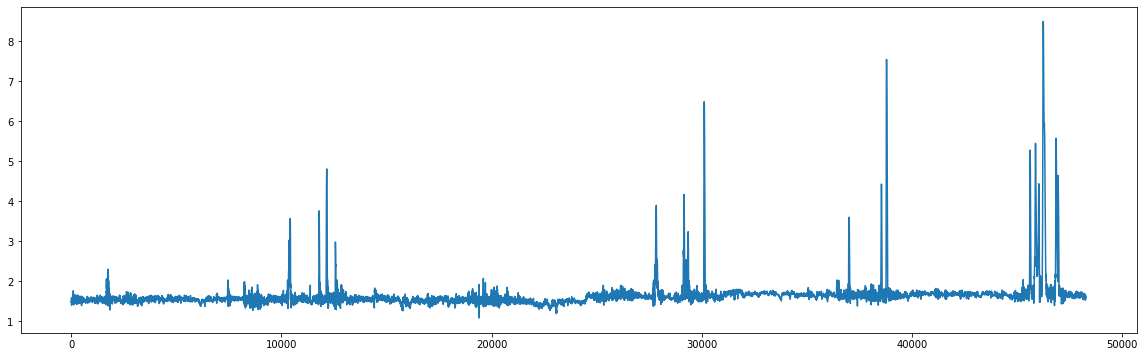

In [ ]:
df_in['2022610'].plot(figsize = (20, 6))

In [ ]:
# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# save the scaler
dump(scaler, open(path + 'scaler_2022610_8.pkl', 'wb'))

df_in_scaled


,2022610,2020675,2020650,2021685,2020680,20224050,20204020,20204030,20214020
0,0.066038,0.057211,0.023929,0.038309,0.036530,0.0,0.0,0.0,0.0
1,0.060647,0.052443,0.022040,0.036988,0.031963,0.0,0.0,0.0,0.0
2,0.057951,0.048868,0.019521,0.035667,0.025114,0.0,0.0,0.0,0.0
3,0.055256,0.046484,0.017632,0.035667,0.020548,0.0,0.0,0.0,0.0
4,0.052561,0.044100,0.015113,0.034346,0.015982,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
48282,0.070081,0.058403,0.401134,0.029062,0.047945,0.0,0.0,0.0,0.0
48283,0.071429,0.060787,0.401134,0.029062,0.047945,0.0,0.0,0.0,0.0
48284,0.072776,0.060787,0.401763,0.029062,0.047945,0.0,0.0,0.0,0.0
48285,0.072776,0.061979,0.401763,0.029062,0.050228,0.0,0.0,0.0,0.0


In [ ]:
# Min=max 정규화 이후 각 값의 차분(미분)을 계산
# 이절차에 있어서는... 가장 좋은 방법에 대한 검토가 필요함
# 일단 차분후 정규화하는 것보다는 정규화 후 차분하는 것이 더 좋다고 판단함

#df_in_scaled['2022610_diff'] = df_in_scaled['2022610'].diff()
#df_in_scaled['2020675_diff'] = df_in_scaled['2020675'].diff()
#df_in_scaled['2020650_diff'] = df_in_scaled['2020650'].diff()
#df_in_scaled['2021685_diff'] = df_in_scaled['2021685'].diff()
#df_in_scaled['2020680_diff'] = df_in_scaled['2020680'].diff()

#df_in_scaled['2022610_diff2'] = df_in_scaled['2022610_diff'].diff().fillna(0)
#df_in_scaled['2020675_diff2'] = df_in_scaled['2020675_diff'].diff().fillna(0)
#df_in_scaled['2020650_diff2'] = df_in_scaled['2020650_diff'].diff().fillna(0)
#df_in_scaled['2021685_diff2'] = df_in_scaled['2021685_diff'].diff().fillna(0)

df_in_scaled

,2022610,2020675,2020650,2021685,2020680,20224050,20204020,20204030,20214020
0,0.066038,0.057211,0.023929,0.038309,0.036530,0.0,0.0,0.0,0.0
1,0.060647,0.052443,0.022040,0.036988,0.031963,0.0,0.0,0.0,0.0
2,0.057951,0.048868,0.019521,0.035667,0.025114,0.0,0.0,0.0,0.0
3,0.055256,0.046484,0.017632,0.035667,0.020548,0.0,0.0,0.0,0.0
4,0.052561,0.044100,0.015113,0.034346,0.015982,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
48282,0.070081,0.058403,0.401134,0.029062,0.047945,0.0,0.0,0.0,0.0
48283,0.071429,0.060787,0.401134,0.029062,0.047945,0.0,0.0,0.0,0.0
48284,0.072776,0.060787,0.401763,0.029062,0.047945,0.0,0.0,0.0,0.0
48285,0.072776,0.061979,0.401763,0.029062,0.050228,0.0,0.0,0.0,0.0


In [ ]:
# 240시간(10일)에 대해 8개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1시간을 예측으로 함

x_range = 240
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = '2022610'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
print(dataset_y_reshaped)

(44928, 240, 9)
[[[0.06603774 0.05721097 0.02392947 ... 0.         0.         0.        ]
  [0.0606469  0.05244338 0.0220403  ... 0.         0.         0.        ]
  [0.05795148 0.0488677  0.01952141 ... 0.         0.         0.        ]
  ...
  [0.05525606 0.04648391 0.0163728  ... 0.         0.         0.        ]
  [0.05390836 0.04529201 0.01574307 ... 0.         0.         0.        ]
  [0.05592992 0.04588796 0.01668766 ... 0.         0.         0.        ]]

 [[0.0606469  0.05244338 0.0220403  ... 0.         0.         0.        ]
  [0.05795148 0.0488677  0.01952141 ... 0.         0.         0.        ]
  [0.05525606 0.04648391 0.01763224 ... 0.         0.         0.        ]
  ...
  [0.05390836 0.04529201 0.01574307 ... 0.         0.         0.        ]
  [0.05592992 0.04588796 0.01668766 ... 0.         0.         0.        ]
  [0.05795148 0.04648391 0.01763224 ... 0.         0.         0.        ]]

 [[0.05795148 0.0488677  0.01952141 ... 0.         0.         0.        ]
  [0.0

In [ ]:
print(np.isnan(dataset_X_reshaped).sum())
print(np.isnan(dataset_y_reshaped).sum())

0
0


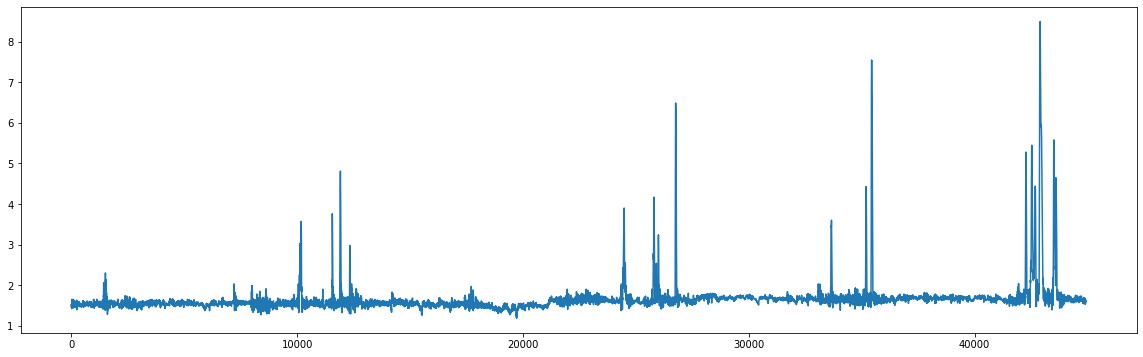

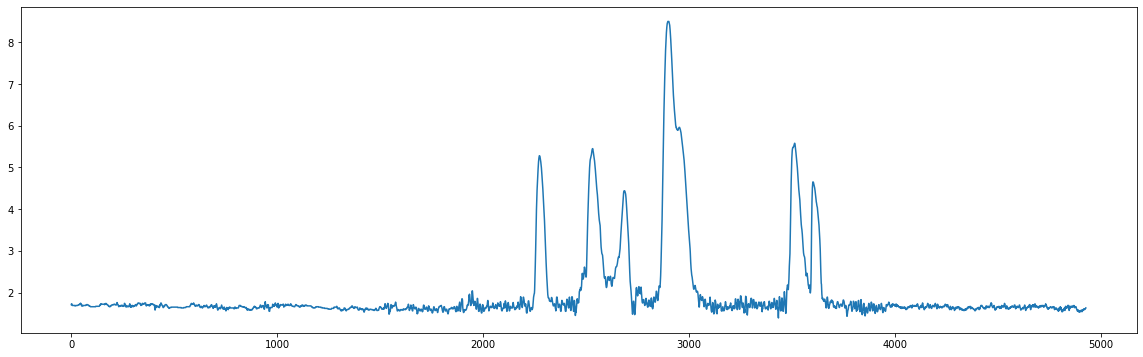

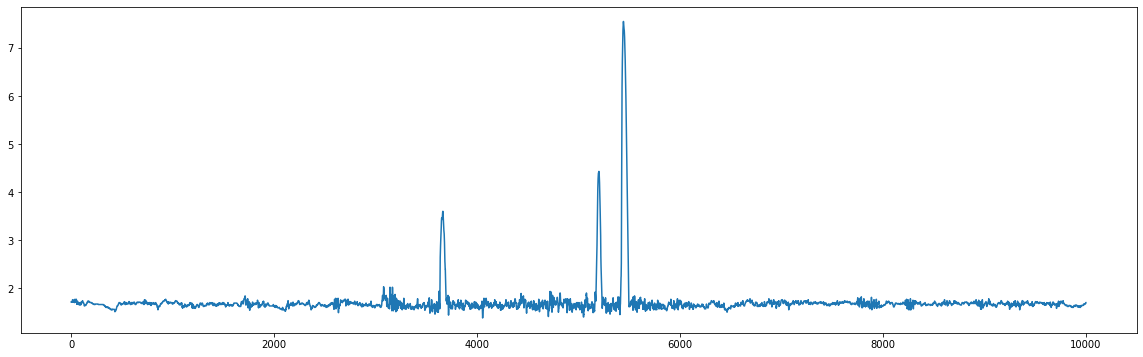

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped)
plt.show()

plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped[40000:])
plt.show()

plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped[30000:40000])
plt.show()

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 50000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:30000,:,:]
X_val = dataset_X_reshaped[30000:40000,:,:]
X_test = dataset_X_reshaped[40000:,:,:]

y_train = dataset_y_reshaped[0:30000]
y_val = dataset_y_reshaped[30000:40000]
y_test = dataset_y_reshaped[40000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 240, 9)
(4928, 240, 9)
(30000, 1)
(4928, 1)


In [ ]:
drop_out_rate = 0.05

In [ ]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음


def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(256, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs, training=True) 
  x = LSTM(256, recurrent_dropout=drop_out_rate)(x, training=True) 
  x = Dropout(drop_out_rate)(x, training=True) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=1024)
  return model
 
model_base = base_lstm(X_train, y_train)


Train on 30000 samples, validate on 10000 samples
Epoch 1/1000
30000/30000 [==============================] - 24s 805us/step - loss: 0.7756 - mae: 0.7263 - val_loss: 0.0840 - val_mae: 0.1611
Epoch 2/1000
30000/30000 [==============================] - 24s 785us/step - loss: 0.0340 - mae: 0.1236 - val_loss: 0.0635 - val_mae: 0.1170
Epoch 3/1000
30000/30000 [==============================] - 24s 789us/step - loss: 0.0207 - mae: 0.0856 - val_loss: 0.0585 - val_mae: 0.1313
Epoch 4/1000
30000/30000 [==============================] - 24s 795us/step - loss: 0.0170 - mae: 0.0791 - val_loss: 0.0555 - val_mae: 0.1421
Epoch 5/1000
30000/30000 [==============================] - 24s 802us/step - loss: 0.0145 - mae: 0.0742 - val_loss: 0.0525 - val_mae: 0.1460
Epoch 6/1000
30000/30000 [==============================] - 24s 804us/step - loss: 0.0121 - mae: 0.0691 - val_loss: 0.0481 - val_mae: 0.1427
Epoch 7/1000
30000/30000 [==============================] - 24s 807us/step - loss: 0.0093 - mae: 0.0634 

In [ ]:
def base_1dcnn(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = Conv1D(filters = 256, kernel_size = 3, padding='valid')(inputs) 
  x = MaxPooling1D(3)(x)
  x = Conv1D(filters = 256, kernel_size = 3, padding='valid')(x) 
  x = MaxPooling1D(3)(x)
  x = Flatten()(x)
  x = Dropout(drop_out_rate)(x, training=True) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=1024)
  return model
 
model_1dcnn = base_1dcnn(X_train, y_train)


Train on 30000 samples, validate on 10000 samples
Epoch 1/1000
30000/30000 [==============================] - 3s 90us/step - loss: 0.4193 - mae: 0.4560 - val_loss: 0.1949 - val_mae: 0.2093
Epoch 2/1000
30000/30000 [==============================] - 2s 79us/step - loss: 0.0533 - mae: 0.1225 - val_loss: 0.1599 - val_mae: 0.2255
Epoch 3/1000
30000/30000 [==============================] - 2s 79us/step - loss: 0.0291 - mae: 0.0808 - val_loss: 0.1944 - val_mae: 0.2544
Epoch 4/1000
30000/30000 [==============================] - 2s 79us/step - loss: 0.0254 - mae: 0.0770 - val_loss: 0.2459 - val_mae: 0.2856
Epoch 5/1000
30000/30000 [==============================] - 2s 80us/step - loss: 0.0227 - mae: 0.0727 - val_loss: 0.3054 - val_mae: 0.3180
Epoch 6/1000
30000/30000 [==============================] - 2s 79us/step - loss: 0.0205 - mae: 0.0705 - val_loss: 0.2817 - val_mae: 0.3012
Epoch 7/1000
30000/30000 [==============================] - 2s 80us/step - loss: 0.0184 - mae: 0.0677 - val_loss: 0.

In [ ]:
def base_dnn(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = Flatten()(inputs)
  x = Dense(256, activation='relu')(x)
  x = Dropout(drop_out_rate)(x, training=True) 
  x = Dense(256,activation='relu')(x)
  x = Dropout(drop_out_rate)(x, training=True) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=1024)

  return model
 
model_dnn = base_dnn(X_train, y_train)



Train on 30000 samples, validate on 10000 samples
Epoch 1/1000
30000/30000 [==============================] - 1s 22us/step - loss: 0.4139 - mae: 0.4431 - val_loss: 0.2217 - val_mae: 0.2967
Epoch 2/1000
30000/30000 [==============================] - 0s 14us/step - loss: 0.0668 - mae: 0.1840 - val_loss: 0.1807 - val_mae: 0.3172
Epoch 3/1000
30000/30000 [==============================] - 0s 14us/step - loss: 0.0279 - mae: 0.1239 - val_loss: 0.4279 - val_mae: 0.4077
Epoch 4/1000
30000/30000 [==============================] - 0s 14us/step - loss: 0.0180 - mae: 0.1014 - val_loss: 0.7258 - val_mae: 0.4946
Epoch 5/1000
30000/30000 [==============================] - 0s 14us/step - loss: 0.0142 - mae: 0.0914 - val_loss: 0.8475 - val_mae: 0.5214
Epoch 6/1000
30000/30000 [==============================] - 0s 14us/step - loss: 0.0117 - mae: 0.0834 - val_loss: 0.9321 - val_mae: 0.5372
Epoch 7/1000
30000/30000 [==============================] - 0s 14us/step - loss: 0.0103 - mae: 0.0778 - val_loss: 0.

In [ ]:
# 테스트 데이터셋에서 수위가 가장높았던 상위 10개 시점의 인덱스를 구함

idx = (-y_test).argsort(axis=None)[:10]
idx

array([2900, 2902, 2901, 2899, 2898, 2897, 2896, 2903, 2895, 2904])

In [ ]:
# 위에서 뽑은 인덱스로 데이터셋을 구성
X_test_high_top10 = X_test[np.array(idx)]
y_test_high_top10 = y_test[np.array(idx)]

In [ ]:
# save model
def save_model(model, fn) :
  json_model = model.to_json()
  json_file = open(fn + '.json', 'w')
  json_file.write(json_model)
  model.save(fn + '.h5')

save_model(model_base, path + 'lstm_base_samrang_wo_diff1')
save_model(model_1dcnn, path + 'lstm_1dcnn_samrang_wo_diff1')
save_model(model_dnn, path + 'dnn_samrang_wo_diff1')


In [ ]:
def predict_dist(X, model, num_samples):
    preds = [model.predict(X) for _ in range(num_samples)]
    return np.hstack(preds)

In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
model = model_base

y_pred_dist = predict_dist(X_test_high_top10, model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
print(np.sqrt(MSE))

print(pred_std.mean())



,Obs,Pred
0,8.50,7.574447
1,8.50,7.632833
2,8.50,7.664867
3,8.50,7.718428
4,8.50,7.562743
5,8.50,7.648979
6,8.49,7.547117
7,8.48,7.628270
8,8.47,7.517831
9,8.46,7.729627


0.8702964520515267
0.30287582


In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
model = model_1dcnn

y_pred_dist = predict_dist(X_test_high_top10, model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
print(np.sqrt(MSE))

print(pred_std.mean())

,Obs,Pred
0,8.50,3.984783
1,8.50,4.143313
2,8.50,4.042589
3,8.50,3.916044
4,8.50,3.813446
5,8.50,3.755207
6,8.49,3.680373
7,8.48,4.193173
8,8.47,3.593259
9,8.46,4.247547


4.5580992040765995
0.070841536


In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
model = model_dnn

y_pred_dist = predict_dist(X_test_high_top10, model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
print(np.sqrt(MSE))

print(pred_std.mean())

,Obs,Pred
0,8.50,7.628729
1,8.50,7.710966
2,8.50,7.741246
3,8.50,7.448221
4,8.50,7.555834
5,8.50,7.507775
6,8.49,7.520864
7,8.48,7.693354
8,8.47,7.203561
9,8.46,7.762342


0.9267266406152902
0.39115462


In [ ]:
strix = 40000

X_test = dataset_X_reshaped[strix:,:,:]
y_test = dataset_y_reshaped[strix:]

print(X_test.shape)
print(y_test.shape)

(4921, 240, 14)
(4921, 1)


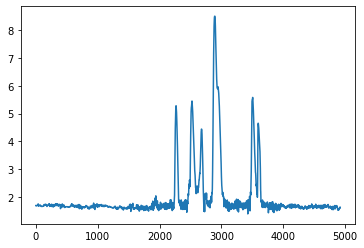

In [ ]:
plt.plot(y_test)

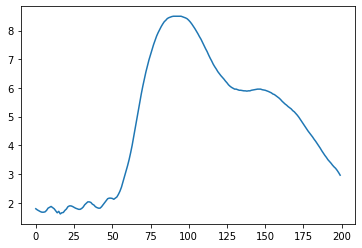

In [ ]:
plt.plot(y_test[2800:3000])

In [ ]:
y_pred_dist = predict_dist(X_test[2800:3000], model_base, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
prob_advisory = [] # 4m
prob_warning = [] # 5m

threshold_advisory = 7
threshold_warning = 8

for i in range(0,len(y_pred_dist)) :
  ecdf = ECDF(y_pred_dist[i])
  prob_advisory.append(1 - ecdf(2))
  prob_warning.append(1 - ecdf(3))

In [ ]:
y_test[2800:3000][:10]

array([[1.79],
       [1.75],
       [1.72],
       [1.69],
       [1.67],
       [1.67],
       [1.68],
       [1.73],
       [1.81],
       [1.84]])

In [ ]:
a = df[df_in['2022610'] == 1.79].index + 4
b = df[df_in['2022610'] == 1.75].index + 3
c = df[df_in['2022610'] == 1.72].index + 2
d = df[df_in['2022610'] == 1.69].index + 1
e = df[df_in['2022610'] == 1.67].index

list(set(a) & set(b) & set(c) & set(d) & set(e))

[46170]

In [ ]:
df[(46170-4):]

,Date,ymdh,2022610,2020675,2020650,2021685,2020680,20224050,20204020,20204030,20214020
46166,2020-08-05 15:00:00,2020080515,1.79,1.48,5.33,1.15,1.63,0.0,0.0,0.0,0.0
46167,2020-08-05 16:00:00,2020080516,1.75,1.45,5.30,1.15,1.61,0.0,0.0,0.0,0.0
46168,2020-08-05 17:00:00,2020080517,1.72,1.42,5.28,1.12,1.58,0.0,0.0,0.0,0.0
46169,2020-08-05 18:00:00,2020080518,1.69,1.39,5.25,1.11,1.56,0.0,0.0,0.0,0.0
46170,2020-08-05 19:00:00,2020080519,1.67,1.36,5.23,1.09,1.53,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
48282,2020-11-01 19:00:00,2020110119,1.60,1.17,4.85,0.85,1.44,0.0,0.0,0.0,0.0
48283,2020-11-01 20:00:00,2020110120,1.61,1.19,4.85,0.85,1.44,0.0,0.0,0.0,0.0
48284,2020-11-01 21:00:00,2020110121,1.62,1.19,4.86,0.85,1.44,0.0,0.0,0.0,0.0
48285,2020-11-01 22:00:00,2020110122,1.62,1.20,4.86,0.85,1.45,0.0,0.0,0.0,0.0


In [ ]:
strix = 46166
num = 200

df_pred = pd.DataFrame({'Date' : df['Date'][strix:strix+num].values, 'Obs' : y_test[2800:3000].flatten(), 'Pred' : pred_mean.flatten(), 'Upper' : pred_mean + 1.96 * pred_std, 'Lower' : pred_mean - 1.96 * pred_std, 'Prob_adv' : prob_advisory, 'Prob_warn' : prob_warning})
#df_pred = df_pred.merge(df[['Date', '10184110', '10184220']], how='left', on = 'Date')
df_pred

,Date,Obs,Pred,Upper,Lower,Prob_adv,Prob_warn
0,2020-08-05 15:00:00,1.79,1.888777,1.940214,1.837340,0.0,0.0
1,2020-08-05 16:00:00,1.75,1.871909,1.928711,1.815106,0.0,0.0
2,2020-08-05 17:00:00,1.72,1.815990,1.876959,1.755021,0.0,0.0
3,2020-08-05 18:00:00,1.69,1.793964,1.849384,1.738544,0.0,0.0
4,2020-08-05 19:00:00,1.67,1.760569,1.832553,1.688586,0.0,0.0
...,...,...,...,...,...,...,...
195,2020-08-13 18:00:00,3.25,3.455576,3.582164,3.328987,1.0,1.0
196,2020-08-13 19:00:00,3.20,3.362868,3.479977,3.245759,1.0,1.0
197,2020-08-13 20:00:00,3.13,3.338497,3.430835,3.246160,1.0,1.0
198,2020-08-13 21:00:00,3.05,3.236420,3.337853,3.134987,1.0,1.0


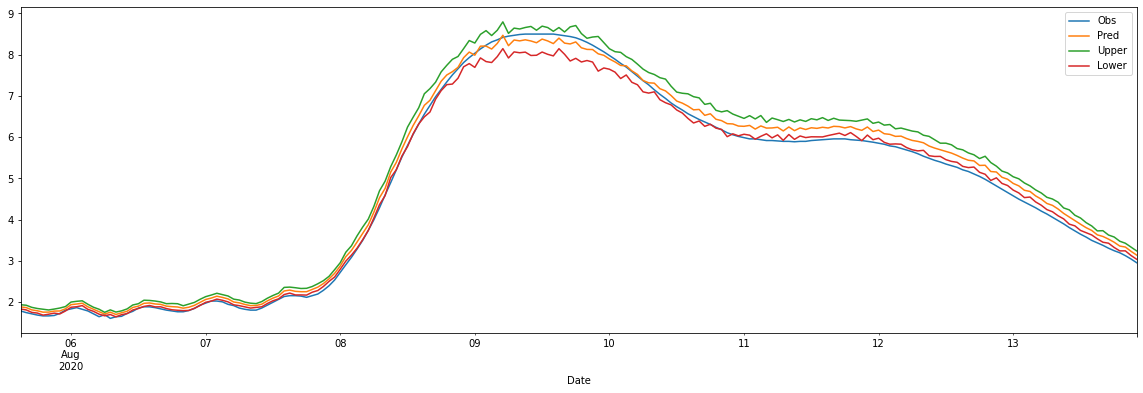

In [ ]:
df_pred[['Date', 'Obs', 'Pred', 'Upper', 'Lower']].set_index('Date').plot(figsize=(20,6))